Segmentation Example, Fully Connvolutional Network, without skip connetions

In [1]:
%%html
<style>.container {width: 100% !important;}</style>

In [2]:
import torch
from torchvision import models, transforms, datasets

In [3]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm

In [4]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

### Create Hyper paramters

In [5]:
n_classes = 21
batch_size = 4
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)


cuda


In [6]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
train_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='train', transform=image_transform, target_transform=mask_transform)
test_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='val', transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


### Show some random images and its mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


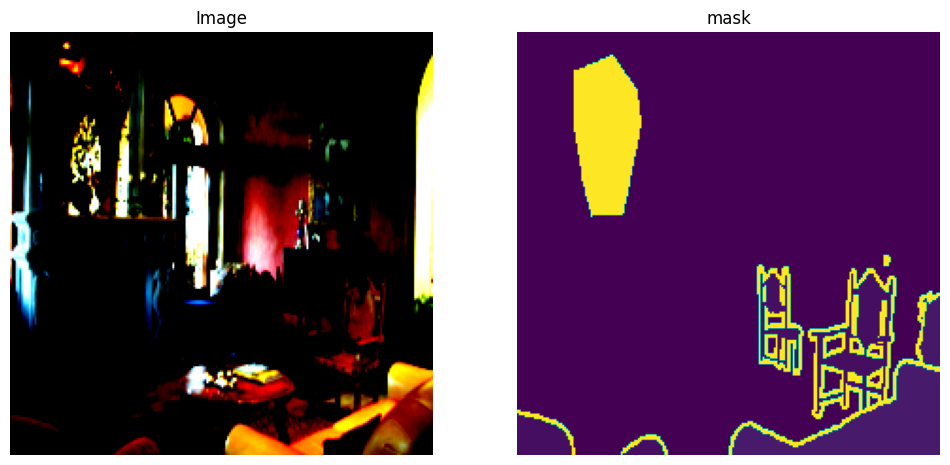

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


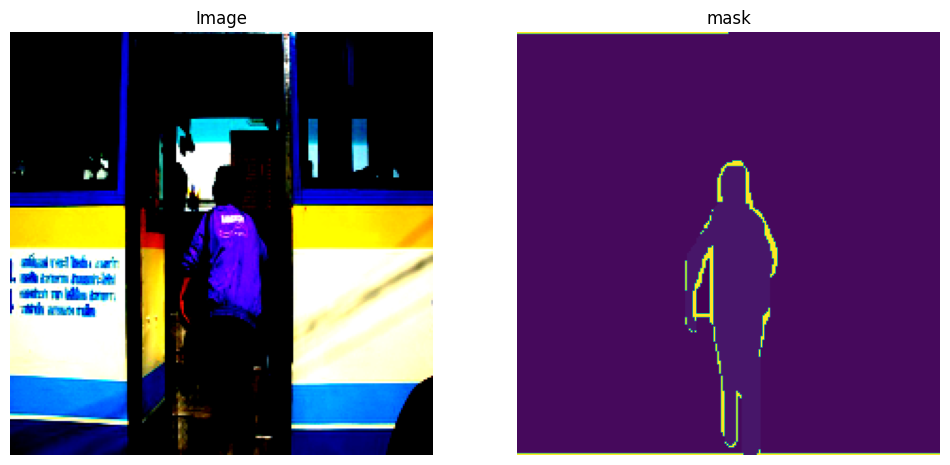

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


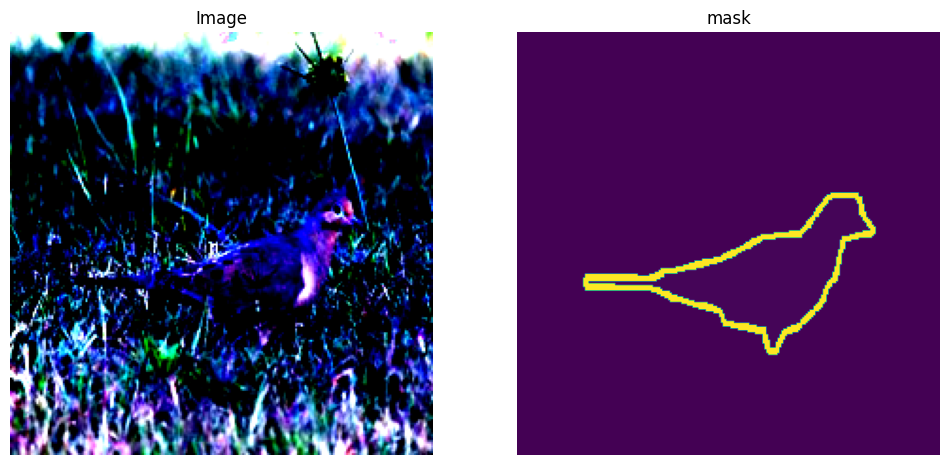

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


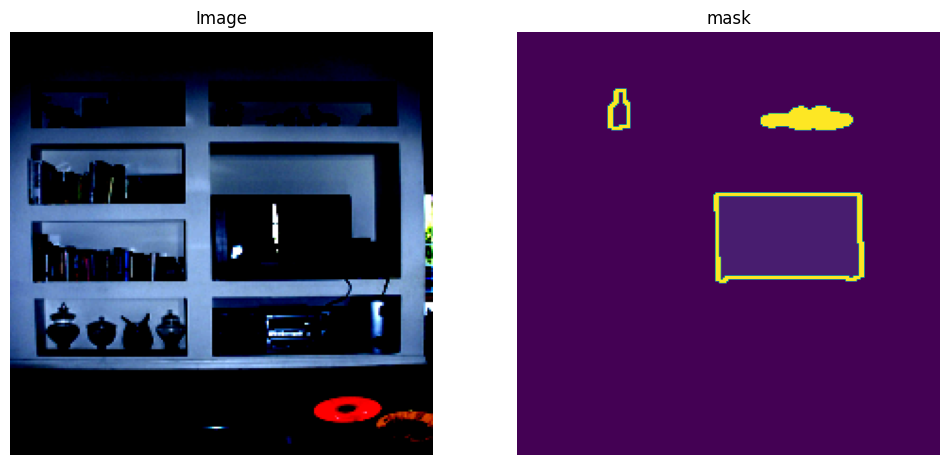

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


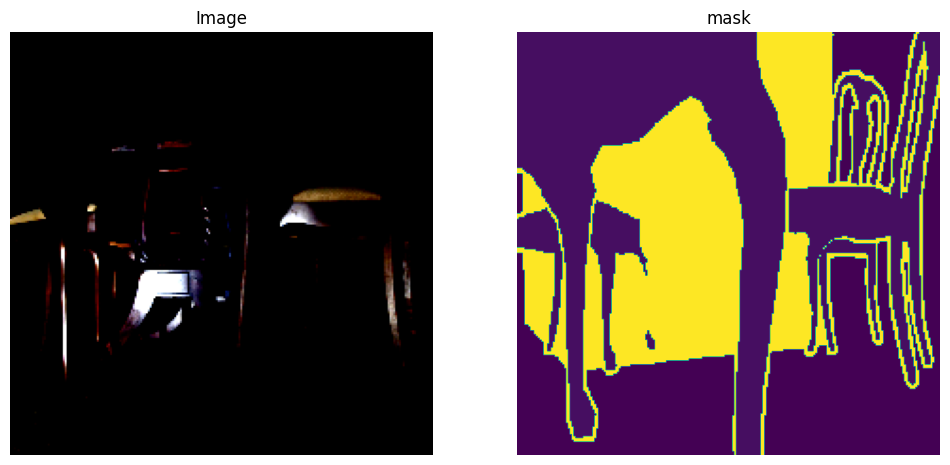

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


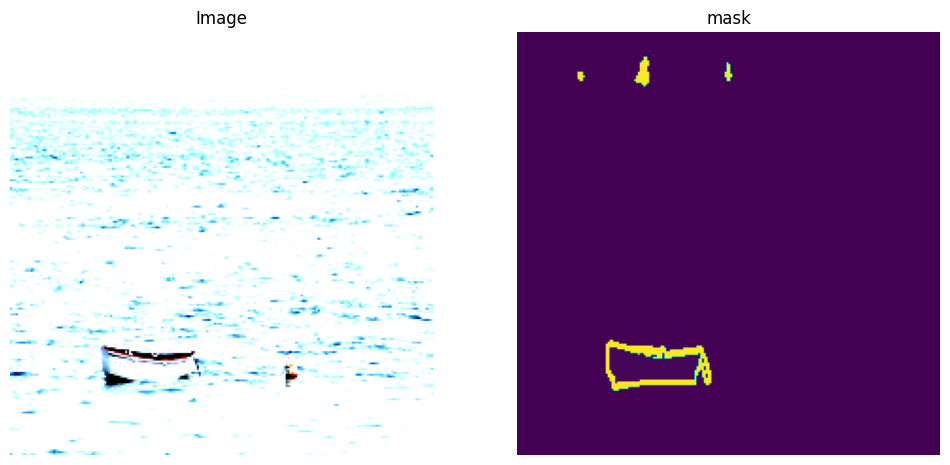

In [8]:
rand_ids = np.random.randint(0, len(test_data), 6)
for id in rand_ids:
    image, mask = test_data[id]
    image = image.permute(1, 2, 0)
    mask = mask.squeeze()
    fig, axis = plt.subplots(1,2,figsize = (12, 6))
    axis[0].imshow(image)
    axis[0].set_title("Image")
    axis[1].imshow(mask)
    axis[1].set_title("mask")
    for ax in axis:
        ax.axis("off")
    plt.show()

## Create a Fully Convolutional Model - No Skip Connections

In [9]:
class FcnModel(nn.Module):
    def __init__(self, n_classes, convert_maxpool = False):
        super().__init__()
        self.n_classes = n_classes
        # Load the VGG16 pretrained model
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Extract features from VGG16
        features = list(vgg.features.children())

        # Convert max pooling to average pooling optional
        if convert_maxpool:
            for i in range(len(features)):
                if isinstance(features[i], nn.MaxPool2d):
                    features[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        # Define the FCN architecture, But back the features in a sequential manner for passing the data
        self.features = nn.Sequential(*features)

        # Upsampling layers using ConvTranspose2d
        self.upsample1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.upsample5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.bn1(self.upsample1(x))
        x = self.bn2(self.upsample2(x))
        x = self.bn3(self.upsample3(x))
        x = self.bn4(self.upsample4(x))
        x = self.bn5(self.upsample5(x))
        x = self.classifier(x)

        return x

In [10]:
model = FcnModel(n_classes=n_classes, convert_maxpool=False).to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# summary(model, input_size=(3, 224, 224))

## Traning And Evaluation

In [11]:
# Training Function
def train_one_epoch(model, train_loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (images, labels) in enumerate(train_bar):
        optimizer.zero_grad()
        images = images.to(device)
        labels = (labels * 255).round() # Move the values back between the 0 and 21, 255 for neglect class.
        labels = labels.squeeze(1).long().to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{train_loss / (batch_idx + 1):.3f}'})

    return train_loss / len(train_loader)

In [12]:
# Validation Loop
def validate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    val_bar = tqdm(test_loader, desc='Validating')
    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = (labels * 255).round().squeeze(1).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #returns the maximum values and their respective indices
            total_correct += (predicted == labels).sum().item()
            total_pixels += labels.nelement()
    return total_correct / total_pixels * 100

In [13]:
def plot_results(train_losses, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'b-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()


Epoch 1/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:59<00:00,  6.13it/s, loss=2.392]


Training Loss: 2.392


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 65.74%
Epoch 2/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.61it/s, loss=1.770]


Training Loss: 1.770


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.91it/s]


Validation Accuracy: 70.54%
Epoch 3/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=1.366]


Training Loss: 1.366


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 15.01it/s]


Validation Accuracy: 73.21%
Epoch 4/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=1.116]


Training Loss: 1.116


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.95it/s]


Validation Accuracy: 74.36%
Epoch 5/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.919]


Training Loss: 0.919


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.95it/s]


Validation Accuracy: 73.03%
Epoch 6/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.776]


Training Loss: 0.776


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 76.74%
Epoch 7/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.676]


Training Loss: 0.676


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 77.41%
Epoch 8/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.58it/s, loss=0.650]


Training Loss: 0.650


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 76.71%
Epoch 9/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.531]


Training Loss: 0.531


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 77.98%
Epoch 10/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.464]


Training Loss: 0.464


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.91it/s]


Validation Accuracy: 78.36%
Epoch 11/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.416]


Training Loss: 0.416


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.93it/s]


Validation Accuracy: 78.68%
Epoch 12/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.371]


Training Loss: 0.371


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.93it/s]


Validation Accuracy: 77.56%
Epoch 13/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.326]


Training Loss: 0.326


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 79.73%
Epoch 14/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.273]


Training Loss: 0.273


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.91it/s]


Validation Accuracy: 78.79%
Epoch 15/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.276]


Training Loss: 0.276


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.92it/s]


Validation Accuracy: 78.86%
Epoch 16/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.61it/s, loss=0.239]


Training Loss: 0.239


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 79.62%
Epoch 17/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.187]


Training Loss: 0.187


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.93it/s]


Validation Accuracy: 80.18%
Epoch 18/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.61it/s, loss=0.147]


Training Loss: 0.147


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.92it/s]


Validation Accuracy: 80.41%
Epoch 19/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.132]


Training Loss: 0.132


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 80.52%
Epoch 20/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.61it/s, loss=0.116]


Training Loss: 0.116


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 80.31%
Epoch 21/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.103]


Training Loss: 0.103


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 80.62%
Epoch 22/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.197]


Training Loss: 0.197


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.98it/s]


Validation Accuracy: 76.54%
Epoch 23/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.61it/s, loss=0.219]


Training Loss: 0.219


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 80.15%
Epoch 24/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.098]


Training Loss: 0.098


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 80.81%
Epoch 25/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.074]


Training Loss: 0.074


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.95it/s]


Validation Accuracy: 80.72%
Epoch 26/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.56it/s, loss=0.063]


Training Loss: 0.063


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 80.95%
Epoch 27/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.063]


Training Loss: 0.063


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 80.99%
Epoch 28/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.057]


Training Loss: 0.057


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.94it/s]


Validation Accuracy: 80.63%
Epoch 29/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.60it/s, loss=0.059]


Training Loss: 0.059


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 80.20%
Epoch 30/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.59it/s, loss=0.260]


Training Loss: 0.260


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.91it/s]


Validation Accuracy: 79.28%


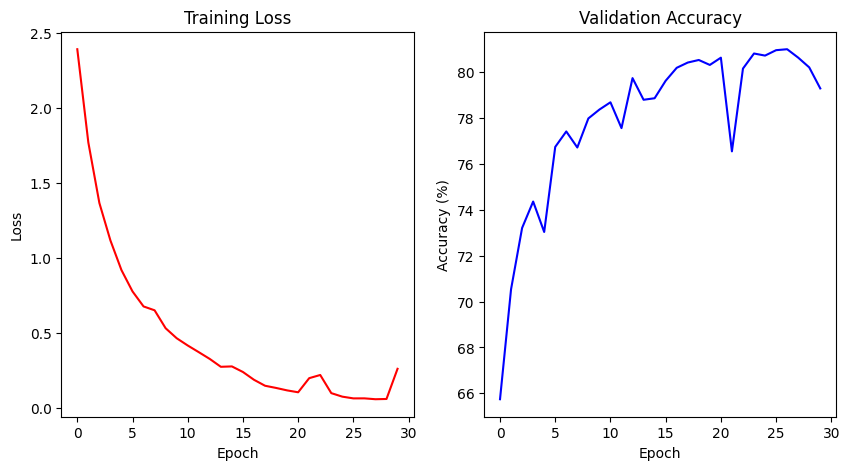

In [14]:
num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs ):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_func, device)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')

    accuracy = validate(model, test_loader, device)
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')

plot_results(train_losses, val_accuracies)

### Test some images

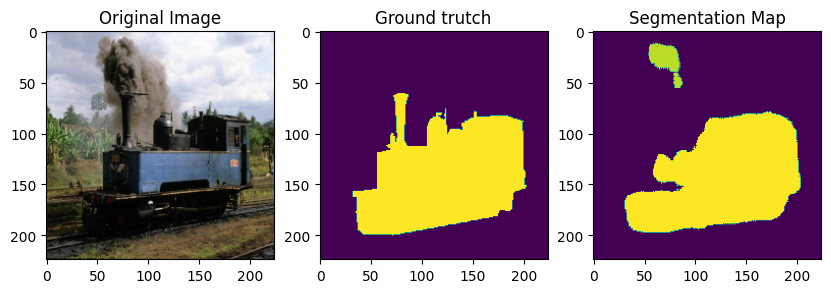

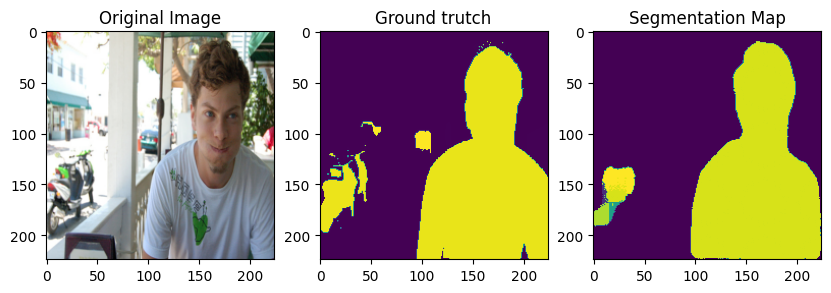

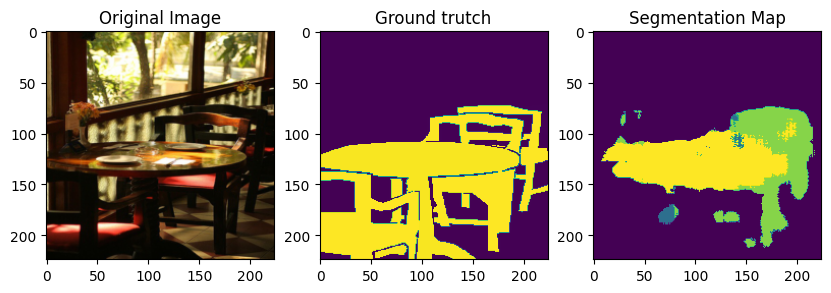

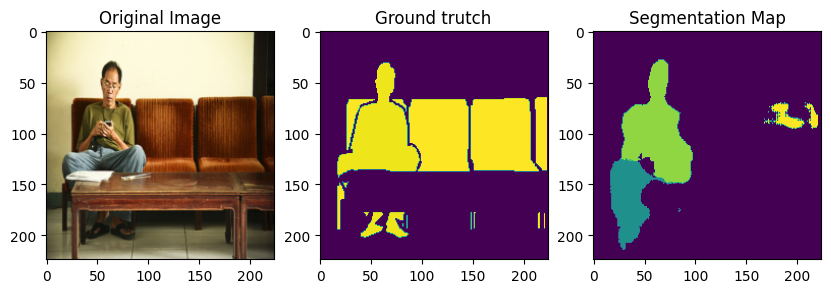

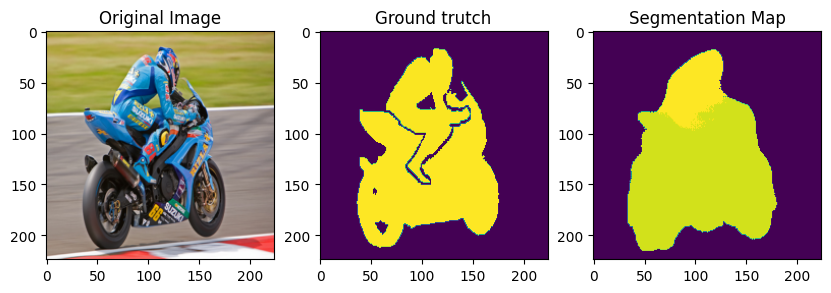

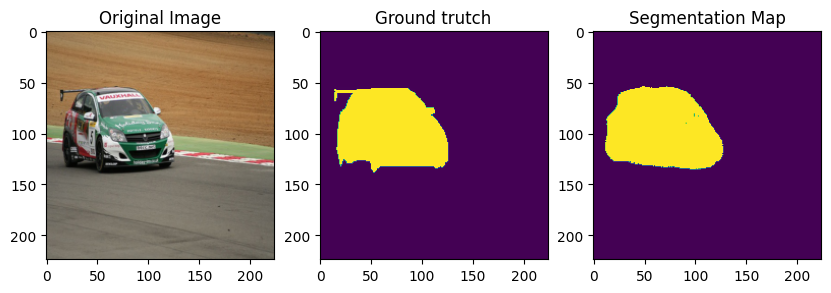

In [15]:
rand_ids = np.random.randint(1,len(test_data), 6)
def unnormalize(tensor):
    """Revert normalization on a tensor."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

model.eval()
with torch.no_grad():
    for id in rand_ids:
        image, ground_truth = test_data[id]
        image_d = image.to(device) 
        ground_truth = ground_truth.squeeze()    
#       image = image.permute(1, 2, 0)
        output = model(image_d.unsqueeze(dim=0))
        # Convert the output tensor to a segmentation map
        _, predicted = torch.max(output.data, 1)
        seg_map = predicted.squeeze().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        #convert the image and mask back to its values 0 to 255 , transform it back from .ToTensor()
        image_unnorm = unnormalize(image.clone())
        ground_truth_unnorm = transforms.ToPILImage()(ground_truth * 255)    
        
        axs[0].imshow(image_unnorm.permute(1,2,0))
        axs[0].title.set_text('Original Image')
        axs[1].imshow(ground_truth_unnorm)
        axs[1].title.set_text('Ground trutch')
        axs[2].imshow(seg_map)
        axs[2].title.set_text('Segmentation Map')
        plt.show()


### Save the Model

In [16]:
torch.save(model.state_dict(), 'model_weights_simple_fcn_no_skip.pth')

In [17]:
# batch_idx = 3  # for example, to get the first batch
# data_iter = iter(train_loader)
# for i in range(batch_idx + 1):
#     img, labels = next(data_iter)

# img = img.to(device)
# out = model(img)
# print(out.shape)
    
# print(out[0][0][77])

# # for value in labels[0]:
# #     print(value[77])

In [18]:
# Training Function

# Fully Convolutional Network - with 8 Skip Connection, pool3, pool4

In [19]:
class FcnModel_8s(nn.Module):
    def __init__(self, n_classes,convert_maxpool = False):
        super().__init__()
        self.n_classes = n_classes
        # Load the VGG16 pretrained model
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Extract features from VGG16
        features = list(vgg.features.children())

        # Define the FCN architecture up to pool3 and pool4
        self.features_pool3 = nn.Sequential(*features[:17])  # up to pool3
        self.features_pool4 = nn.Sequential(*features[17:24])  # up to pool4
        self.features_rest = nn.Sequential(*features[24:])   # rest of the VGG features

        # 1x1 convolutions for pool3 and pool4
        self.score_pool3 = nn.Conv2d(256, 256, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, 512, kernel_size=1)

        # Upsampling layers using ConvTranspose2d
        self.upsample1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.upsample5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # Extract feature maps
        pool3 = self.features_pool3(x)
        pool4 = self.features_pool4(pool3)
        x = self.features_rest(pool4)

        # Upsampling
        x = self.bn1(self.upsample1(x))

        # Skip connection from pool4
        pool4 = self.score_pool4(pool4)
        x = x + pool4  # element-wise addition

        # Upsampling
        x = self.bn2(self.upsample2(x))

        # Skip connection from pool3
        pool3 = self.score_pool3(pool3)
        x = x + pool3  # element-wise addition

        # Continue upsampling
        x = self.bn3(self.upsample3(x))
        x = self.bn4(self.upsample4(x))
        x = self.bn5(self.upsample5(x))
        x = self.classifier(x)

        return x


In [20]:
flush()
model2 = FcnModel_8s(n_classes=n_classes, convert_maxpool=False).to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

Epoch 1/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.52it/s, loss=2.211]


Training Loss: 2.211


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 69.46%
Epoch 2/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=1.637]


Training Loss: 1.637


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 72.94%
Epoch 3/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=1.294]


Training Loss: 1.294


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.85it/s]


Validation Accuracy: 73.48%
Epoch 4/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=1.064]


Training Loss: 1.064


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.85it/s]


Validation Accuracy: 73.31%
Epoch 5/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.905]


Training Loss: 0.905


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.84it/s]


Validation Accuracy: 74.25%
Epoch 6/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.790]


Training Loss: 0.790


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.87it/s]


Validation Accuracy: 75.02%
Epoch 7/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.47it/s, loss=0.692]


Training Loss: 0.692


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.86it/s]


Validation Accuracy: 75.62%
Epoch 8/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.44it/s, loss=0.622]


Training Loss: 0.622


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.86it/s]


Validation Accuracy: 76.46%
Epoch 9/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.562]


Training Loss: 0.562


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 76.93%
Epoch 10/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.501]


Training Loss: 0.501


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 77.56%
Epoch 11/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.431]


Training Loss: 0.431


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 75.62%
Epoch 12/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.495]


Training Loss: 0.495


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 78.27%
Epoch 13/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.344]


Training Loss: 0.344


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 79.33%
Epoch 14/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.285]


Training Loss: 0.285


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.86it/s]


Validation Accuracy: 80.24%
Epoch 15/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.235]


Training Loss: 0.235


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 79.44%
Epoch 16/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.54it/s, loss=0.211]


Training Loss: 0.211


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.87it/s]


Validation Accuracy: 80.39%
Epoch 17/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.192]


Training Loss: 0.192


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 80.25%
Epoch 18/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.51it/s, loss=0.171]


Training Loss: 0.171


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 79.86%
Epoch 19/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.143]


Training Loss: 0.143


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 80.65%
Epoch 20/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.54it/s, loss=0.140]


Training Loss: 0.140


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.91it/s]


Validation Accuracy: 80.41%
Epoch 21/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.238]


Training Loss: 0.238


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.87it/s]


Validation Accuracy: 78.85%
Epoch 22/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.184]


Training Loss: 0.184


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.87it/s]


Validation Accuracy: 80.14%
Epoch 23/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.102]


Training Loss: 0.102


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.89it/s]


Validation Accuracy: 81.06%
Epoch 24/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.080]


Training Loss: 0.080


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 81.26%
Epoch 25/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.068]


Training Loss: 0.068


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 81.35%
Epoch 26/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.063]


Training Loss: 0.063


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.88it/s]


Validation Accuracy: 80.81%
Epoch 27/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.54it/s, loss=0.147]


Training Loss: 0.147


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.90it/s]


Validation Accuracy: 78.28%
Epoch 28/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.129]


Training Loss: 0.129


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.86it/s]


Validation Accuracy: 80.82%
Epoch 29/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:56<00:00,  6.53it/s, loss=0.079]


Training Loss: 0.079


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.93it/s]


Validation Accuracy: 80.74%
Epoch 30/30


Training: 100%|█████████████████████████████████████████████████████████| 366/366 [00:55<00:00,  6.54it/s, loss=0.055]


Training Loss: 0.055


Validating: 100%|███████████████████████████████████████████████████████████████████| 363/363 [00:24<00:00, 14.81it/s]


Validation Accuracy: 81.36%


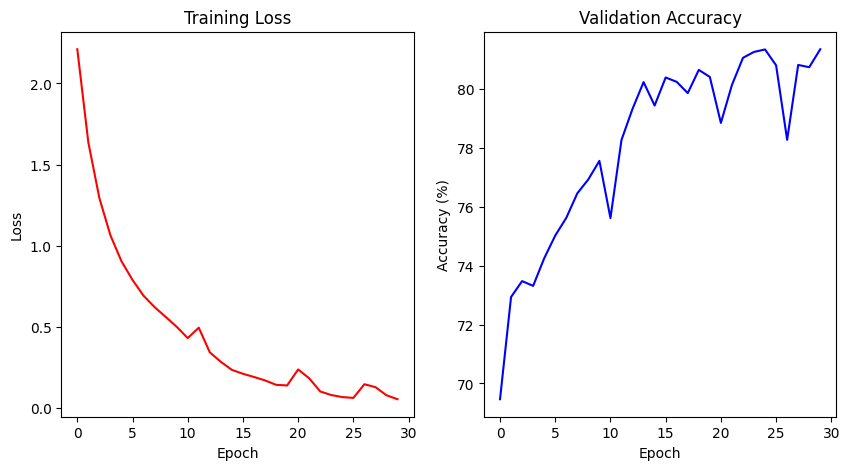

In [21]:
flush()
num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs ):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(model2, train_loader, optimizer, loss_func, device)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')

    accuracy = validate(model2, test_loader, device)
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')

plot_results(train_losses, val_accuracies)

In [22]:
torch.save(model2.state_dict(), 'model_weights_simple_fcn_with_skip_8s.pth')